# Corrélation Age-Categ
## Quanti/Quali

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from matplotlib import gridspec
from datetime import datetime
from statsmodels.formula.api import ols
from scipy.stats import bartlett
from scipy.stats import shapiro

In [2]:
# Déclaration d'une fonction
def analyseDataFrame(df):
    """Fonction qui prend en arguments un dataframe pour analyse."""

    name =[x for x in globals() if globals()[x] is df][0]
    print("La dimension de DataFrame « " + name  +" » : " + str(df.shape) + " (lignes, colonnes)\n")
    display(df.info())
    display(df.head())
    display(df.describe().T)
    display(df.nunique())

In [3]:
# Importation du dataFrame 'df_enrichi'
df_enrichi = pd.read_csv("df_enrichi.csv", index_col="date_2", parse_dates= True)

# Vérifier que la première colonne est une idex
df_enrichi.index = pd.to_datetime(df_enrichi.index)

# Trier sur la colonne date
df_enrichi = df_enrichi.sort_index()

# Visualisualisation de df_enrichi
analyseDataFrame(df_enrichi)

La dimension de DataFrame « df_enrichi » : (679111, 11) (lignes, colonnes)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679111 entries, 2021-03-01 00:01:07.843138 to 2023-02-28 23:58:30.792755
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  679111 non-null  int64  
 1   client_id   679111 non-null  object 
 2   sex         679111 non-null  object 
 3   birth       679111 non-null  float64
 4   age         679111 non-null  float64
 5   id_prod     679111 non-null  object 
 6   date        679111 non-null  object 
 7   session_id  679111 non-null  object 
 8   price       679111 non-null  float64
 9   categ       679111 non-null  float64
 10  _merge      679111 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 62.2+ MB


None

,Unnamed: 0,client_id,sex,birth,age,id_prod,date,session_id,price,categ,_merge
date_2,,,,,,,,,,,
2021-03-01 00:01:07.843138,129502,c_329,f,1967.0,55.0,0_1259,2021-03-01 00:01:07.843138,s_1,11.99,0.0,both
2021-03-01 00:02:26.047414,17306,c_664,m,1960.0,62.0,0_1390,2021-03-01 00:02:26.047414,s_2,19.37,0.0,both
2021-03-01 00:02:38.311413,146527,c_580,m,1988.0,34.0,0_1352,2021-03-01 00:02:38.311413,s_3,4.50,0.0,both
2021-03-01 00:04:54.559692,506717,c_7912,f,1989.0,33.0,0_1458,2021-03-01 00:04:54.559692,s_4,6.55,0.0,both
2021-03-01 00:05:18.801198,218220,c_2033,f,1956.0,66.0,0_1358,2021-03-01 00:05:18.801198,s_5,16.49,0.0,both


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,679111.0,339599.602812,196104.276737,0.00,169777.50,339555.00,509332.50,679331.0
birth,679111.0,1977.811149,13.575361,1929.00,1970.00,1980.00,1987.00,2004.0
age,679111.0,44.188851,13.575361,18.00,35.00,42.00,52.00,93.0
price,679111.0,17.454773,18.328998,0.62,8.87,13.99,18.99,300.0
categ,679111.0,0.441953,0.595042,0.00,0.00,0.00,1.00,2.0


Unnamed: 0    679111
client_id       8600
sex                2
birth             76
age               76
id_prod         3265
date          679111
session_id    342275
price           1442
categ              3
_merge             1
dtype: int64

In [4]:
X = "age" # Quanti
Y = "categ" # Quali

c = df_enrichi[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = df_enrichi[X].value_counts()
ty = df_enrichi[Y].value_counts()

cont.loc[:, "Total"] = tx
cont.loc["total", :] = ty
cont.loc["total", "Total"] = len(df_enrichi)

cont

categ,0.0,1.0,2.0,Total
age,,,,
18.0,3418.0,5719.0,6012.0,15149.0
19.0,909.0,1678.0,1784.0,4371.0
20.0,1016.0,1723.0,1845.0,4584.0
21.0,974.0,1550.0,1728.0,4252.0
22.0,1114.0,1628.0,1671.0,4413.0
...,...,...,...,...
90.0,132.0,177.0,2.0,311.0
91.0,77.0,91.0,2.0,170.0
92.0,75.0,149.0,2.0,226.0


## ANOVA à 1 facteur (Catégorie et âge)

On veut étudier ici l'influence de la catégorie sur le prix du produit.

On peut visualiser l'influence de la catégorie en affichant ces boîtes à moustaches :

In [5]:
df_age_categ = df_enrichi[["client_id","age", "categ"]].copy()

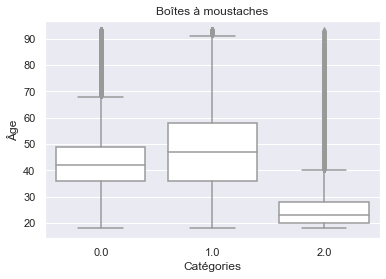

In [6]:
sns.set()

ax = sns.boxplot(x="categ", y="age", data=df_age_categ, color='white')
plt.xlabel('Catégories')
plt.ylabel('Âge')
plt.title('Boîtes à moustaches')
plt.show()

### Les 3 variétés semblent assez différentes, même si l'ordre de grandeur de ces écarts n'est pas très grand. La question sera de savoir si ces écarts sont significatifs ou pas.
<div style=" background-color: rgb(135,206,250);" >
    <h1 style="text-align: center;" >C'est l'ANOVA qui nous permettra de répondre à cette question.</h1>
</div>

In [7]:
import statsmodels.formula.api as smf

anova_variete = smf.ols('categ~age', data=df_age_categ).fit()
print(anova_variete.summary())

                            OLS Regression Results                            
Dep. Variable:                  categ   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6755.
Date:                Sat, 30 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:39:30   Log-Likelihood:            -6.0771e+05
No. Observations:              679111   AIC:                         1.215e+06
Df Residuals:                  679109   BIC:                         1.215e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6342      0.002    259.199      0.0

On y voit les paramètres estimés (dans la colonne "coef"), mais ici, ce ne sont pas les paramètres qui nous intéressent le plus.

## Réalisez un test de Fisher


Pour obtenir le tableau de l'analyse de la variance, on utilise la commande anova_lm :

In [8]:
test_anova = sm.stats.anova_lm(anova_variete, typ=2)
test_anova

,sum_sq,df,F,PR(>F)
age,2368.175683,1.0,6754.872084,0.0
Residual,238087.324207,679109.0,NaN,NaN


Ce qui nous intéresse réellement, c'est le **test de Fisher**.
La p-valeur de ce test ($0.0$) est très petite et largement inférieure à 5 %. On rejette donc l'hypothèse H0 selon laquelle $α_{1}=α_{2}=α_{3}=0$.

*La catégorie a donc bien un effet sur l'âge, comme nous en avions l'intuition en regardant les boîtes à moustaches.*



In [9]:
p_value = test_anova[test_anova.index == 'age']['PR(>F)']
print("p_value", p_value[0] )
alpha = 0.05

x_name = 'categ'
y_name = 'âge'

if p_value[0] > alpha:
    print(f"Probablement independente : Probablement la variable « {x_name} » n'est pas liée à la variable « {y_name} »")
else:
    print(f"Probablement dependente : Probablement la variable « {x_name} » est liée à la variable « {y_name} »")


p_value 0.0
Probablement dependente : Probablement la variable « categ » est liée à la variable « âge »


On obtient un p_value à $0.0$ (<=0.05), ce qui laisse penser qu'il y a effectivement une corrélation entre la catégorie et âge.

### Analyse de la corrélation en utilisant le calcul de $\eta^2$ (eta carré ou eta squared en anglais)

In [10]:
X = "categ" # Quali
Y = "age" # Quanti

sous_echantillon = df_enrichi[df_enrichi["price"] > 0]

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({"ni": len(yi_classe),
                        "moyenne_classe": yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c["ni"]*(c["moyenne_classe"]-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta2 = eta_squared(sous_echantillon[X], sous_echantillon[Y])

print("eta_squared = ", round(eta2,2))

alpha = 0.05

x_name = 'categ'
y_name = 'age'

if eta2 > alpha:
   print(f"Probablement dependente : Probablement la variable « {x_name} » est liée à la variable « {y_name} ».")
else:
     print(f"Probablement independente : Probablement la variable « {x_name} » n'est pas liée à la variable « {y_name} ».")


eta_squared =  0.12
Probablement dependente : Probablement la variable « categ » est liée à la variable « age ».


On obtient un résultat proche de $0.12$ (>0.05), ce qui laisse penser qu'il y a effectivement une corrélation entre la catégorie et âge.